# <span style='font-family:"Times New Roman"'> <span styel=''>**WGD COHORT - SUBGROUPS PROPORTIONS**

*Emile Cohen*
    
*June 2020*

**Goal**: In this notebook, we compute the proportion plots for the different subgroups per cancer.

---

In [1]:
%run -i '../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
import pickle

data_path = '../../../data/'
data_wgd = data_path + 'impact-facets-tp53/processed/wgd/'
data_no_wgd = data_path + 'impact-facets-tp53/processed/no_wgd/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

In [2]:
master_wgd = pd.read_pickle(data_path + 'impact-facets-tp53/processed/wgd/master_wgd.pkl')

cancer_count = get_groupby(master_wgd, 'Cancer_Type', 'count').sort_values(by='count', ascending = False)
cancer_list = list(cancer_count[cancer_count['count']>=50].index.values)

In [3]:
get_groupby(master_wgd, 'prewgd_tp53_group_1', 'count')

,count
prewgd_tp53_group_1,
bi,3289
tp53_res,2808


In [4]:
def create_pre_total(x):
    if x.prewgd_tp53_group_1 == 'bi':
        return 'bi'
    elif x.prewgd_tp53_group_1 == 'tp53_res':
        return 'tp53_res'
    else:
        return 'uncertain'
    
master_wgd['prewgd_tp53_group_1_total'] = master_wgd.apply(create_pre_total, axis=1)

In [16]:
get_groupby(master_wgd, 'prewgd_tp53_group_1_total', 'count')

,count
prewgd_tp53_group_1_total,
bi,3289
tp53_res,2808
uncertain,270


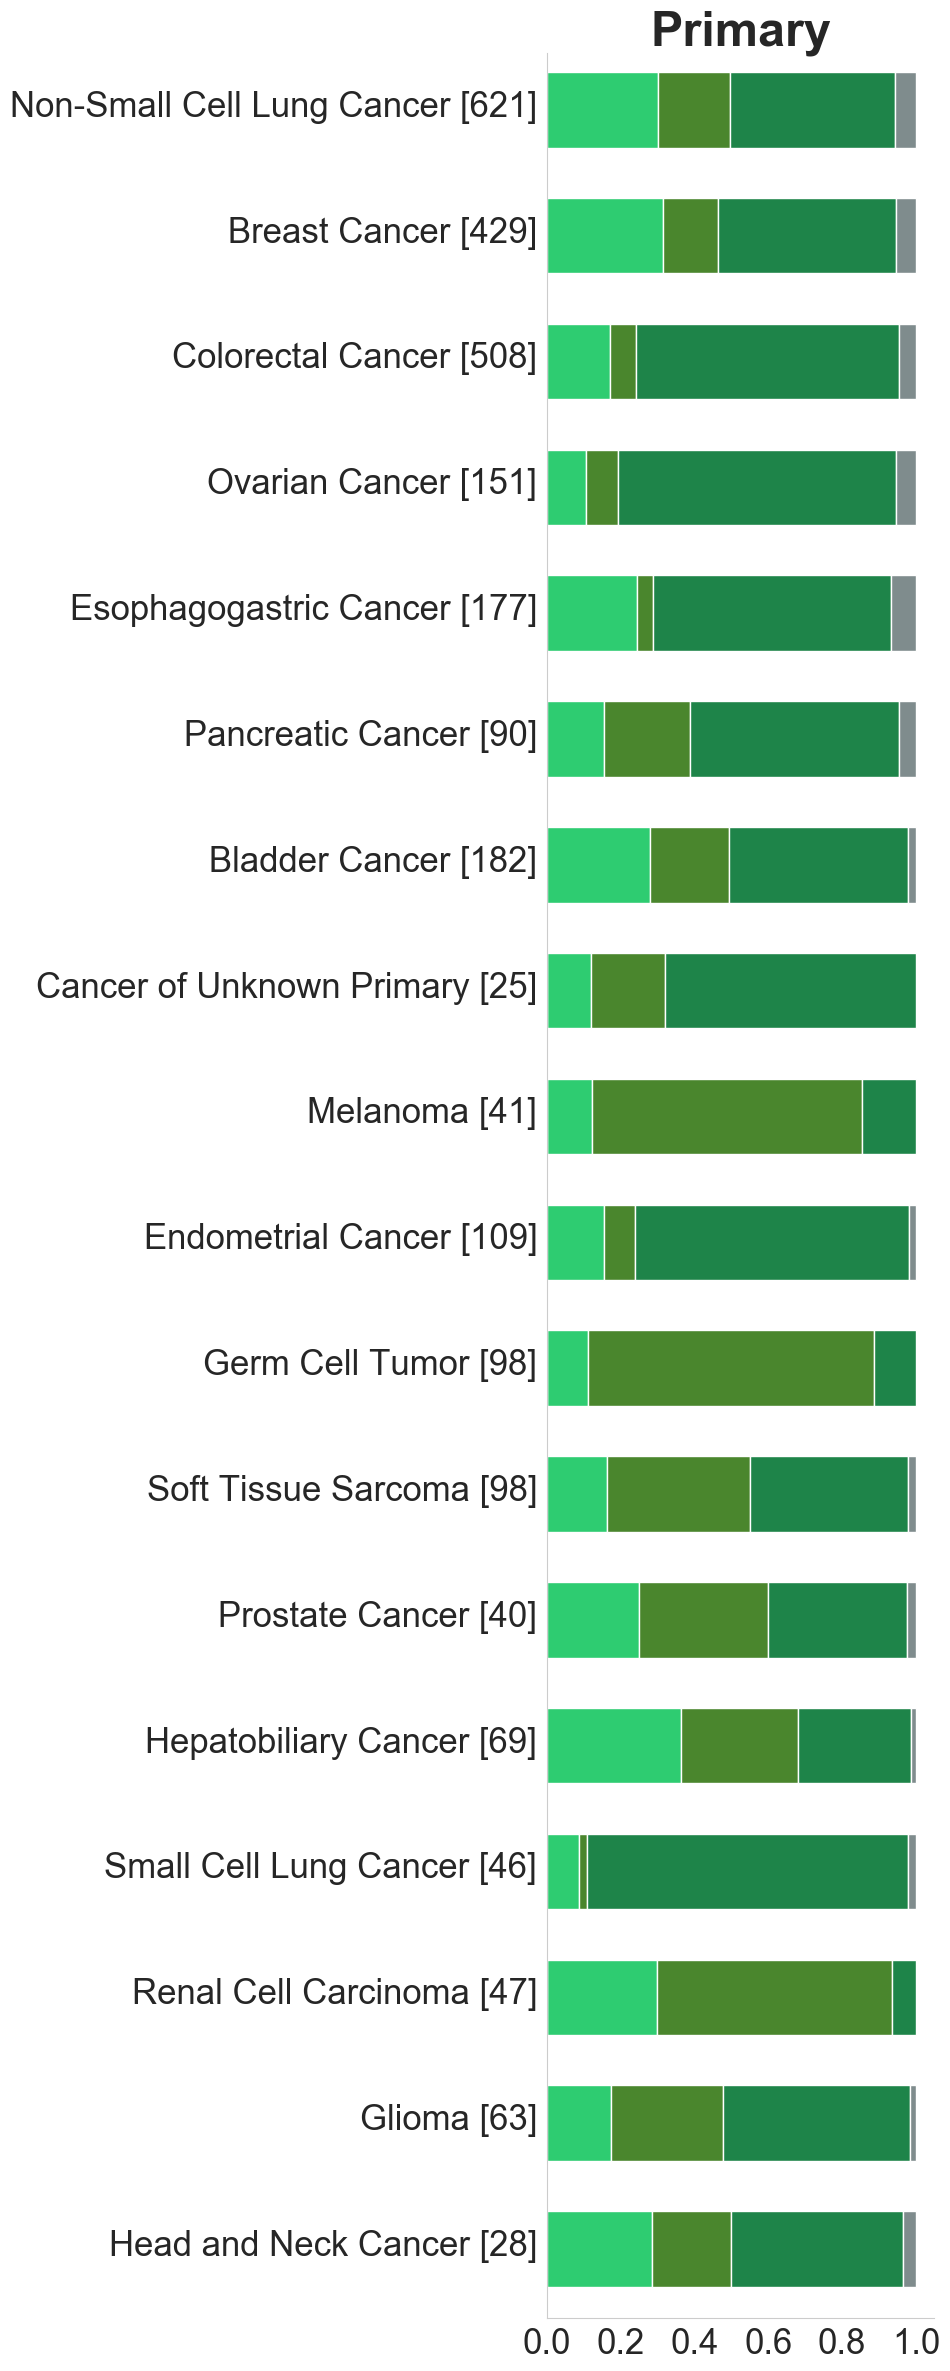

In [20]:
sns.set_style("whitegrid", {'grid.color': '1.'})

fig, ax = plt.subplots(figsize=(5,30))

def plot_metrics_cancerlist(master: pd.DataFrame, metrics: str, prim_met: str, ax,  legend=True):
    for i, cancer_type in enumerate(cancer_list):
        master_cancer = master[master['Cancer_Type'] == cancer_type][master['tp53_cn_state'] != 'INDETERMINATE'][~master['tp53_cn_state'].isna()]
        count_prim_met = get_groupby(master_cancer[master_cancer['Sample_Type'] == prim_met], metrics, 'count_prim_met' + metrics)
        freq_prim_met = pd.DataFrame(count_prim_met['count_prim_met' + metrics]).sort_values(by=['count_prim_met' + metrics], ascending=False)/ pd.DataFrame(count_prim_met['count_prim_met' + metrics]).sum()
        if legend:
            freq_prim_met.columns=[cancer_type + ' ' + str(pd.DataFrame(count_prim_met['count_prim_met' + metrics]).sum().values)]
        else:
            freq_prim_met.columns=[str(pd.DataFrame(count_prim_met['count_prim_met' + metrics]).sum().values)]
        if metrics == 'prewgd_tp53_group_1':
            freq_prim_met = freq_prim_met.reindex(bi_list)
        elif metrics == 'tp53_mut_loh_group':
            freq_prim_met = freq_prim_met.reindex(['0_noloh', '0_loh', '1_noloh', '1_loh'])
        elif metrics == 'tp53_loh_status':
            freq_prim_met = freq_prim_met.reindex(loh_list)
        elif metrics == 'prewgd_tp53_group_1_hit':
            freq_prim_met = freq_prim_met.reindex(['tp53_res_hit', 'tp53_res_no_hit','bi', 'uncertain'])
        elif metrics == 'prewgd_tp53_group_1_total':
            freq_prim_met = freq_prim_met.reindex(['tp53_res', 'bi', 'uncertain'])
    
            
        if i==0:
            freq_prim_met_final = freq_prim_met.T
        else : freq_prim_met_final = pd.concat([freq_prim_met_final, freq_prim_met.T], axis=0)

    #display(freq_prim_met_final)
    freq_prim_met_final = freq_prim_met_final.fillna(0)
    
    if metrics == 'prewgd_tp53_group_1':
        h = freq_prim_met_final[::-1].plot(kind = 'barh', stacked=True, ax=ax, yticks=[0,0.25,0.5,0.75,1], color=bi_palette_list)
    elif metrics == 'tp53_mut_loh_group':
        h = freq_prim_met_final[::-1].plot(kind = 'barh', stacked=True, ax=ax, yticks=[0,0.25,0.5,0.75,1], color=tab10)
    elif metrics == 'tp53_loh_status':
        h = freq_prim_met_final[::-1].plot(kind = 'barh', stacked=True, ax=ax, yticks=[0,0.25,0.5,0.75,1], color=loh_palette_list)
    elif metrics == 'prewgd_tp53_group_1_hit':
        h = freq_prim_met_final[::-1].plot(kind = 'barh', stacked=True, ax=ax, yticks=[0,0.25,0.5,0.75,1], color=['#2ECC71','#4A862D','#1E8449','#7F8C8D'])
    elif metrics == 'prewgd_tp53_group_1_total':
        h = freq_prim_met_final[::-1].plot(kind = 'barh', stacked=True, ax=ax, yticks=[0,0.25,0.5,0.75,1], color=['#2ECC71', '#1E8449','#7F8C8D'])



    ax.set_title(prim_met, weight = 'bold', fontsize=35)
    ax.legend_.remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

    for container in ax.containers:
        for i, child in enumerate(container.get_children()):
            child.set_height(0.6)

    ax.set_yticks([k + 0.1 for k in list(range(len(cancer_list)))])
    
    #if legend == False:
    #h.axes.get_yaxis().set_ticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(25) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)
    
plot_metrics_cancerlist(master=master_wgd,
                        metrics='prewgd_tp53_group_1_hit', 
                        prim_met='Primary', 
                        ax=ax,  
                        legend=True)

# Mutation/Loh subgroup

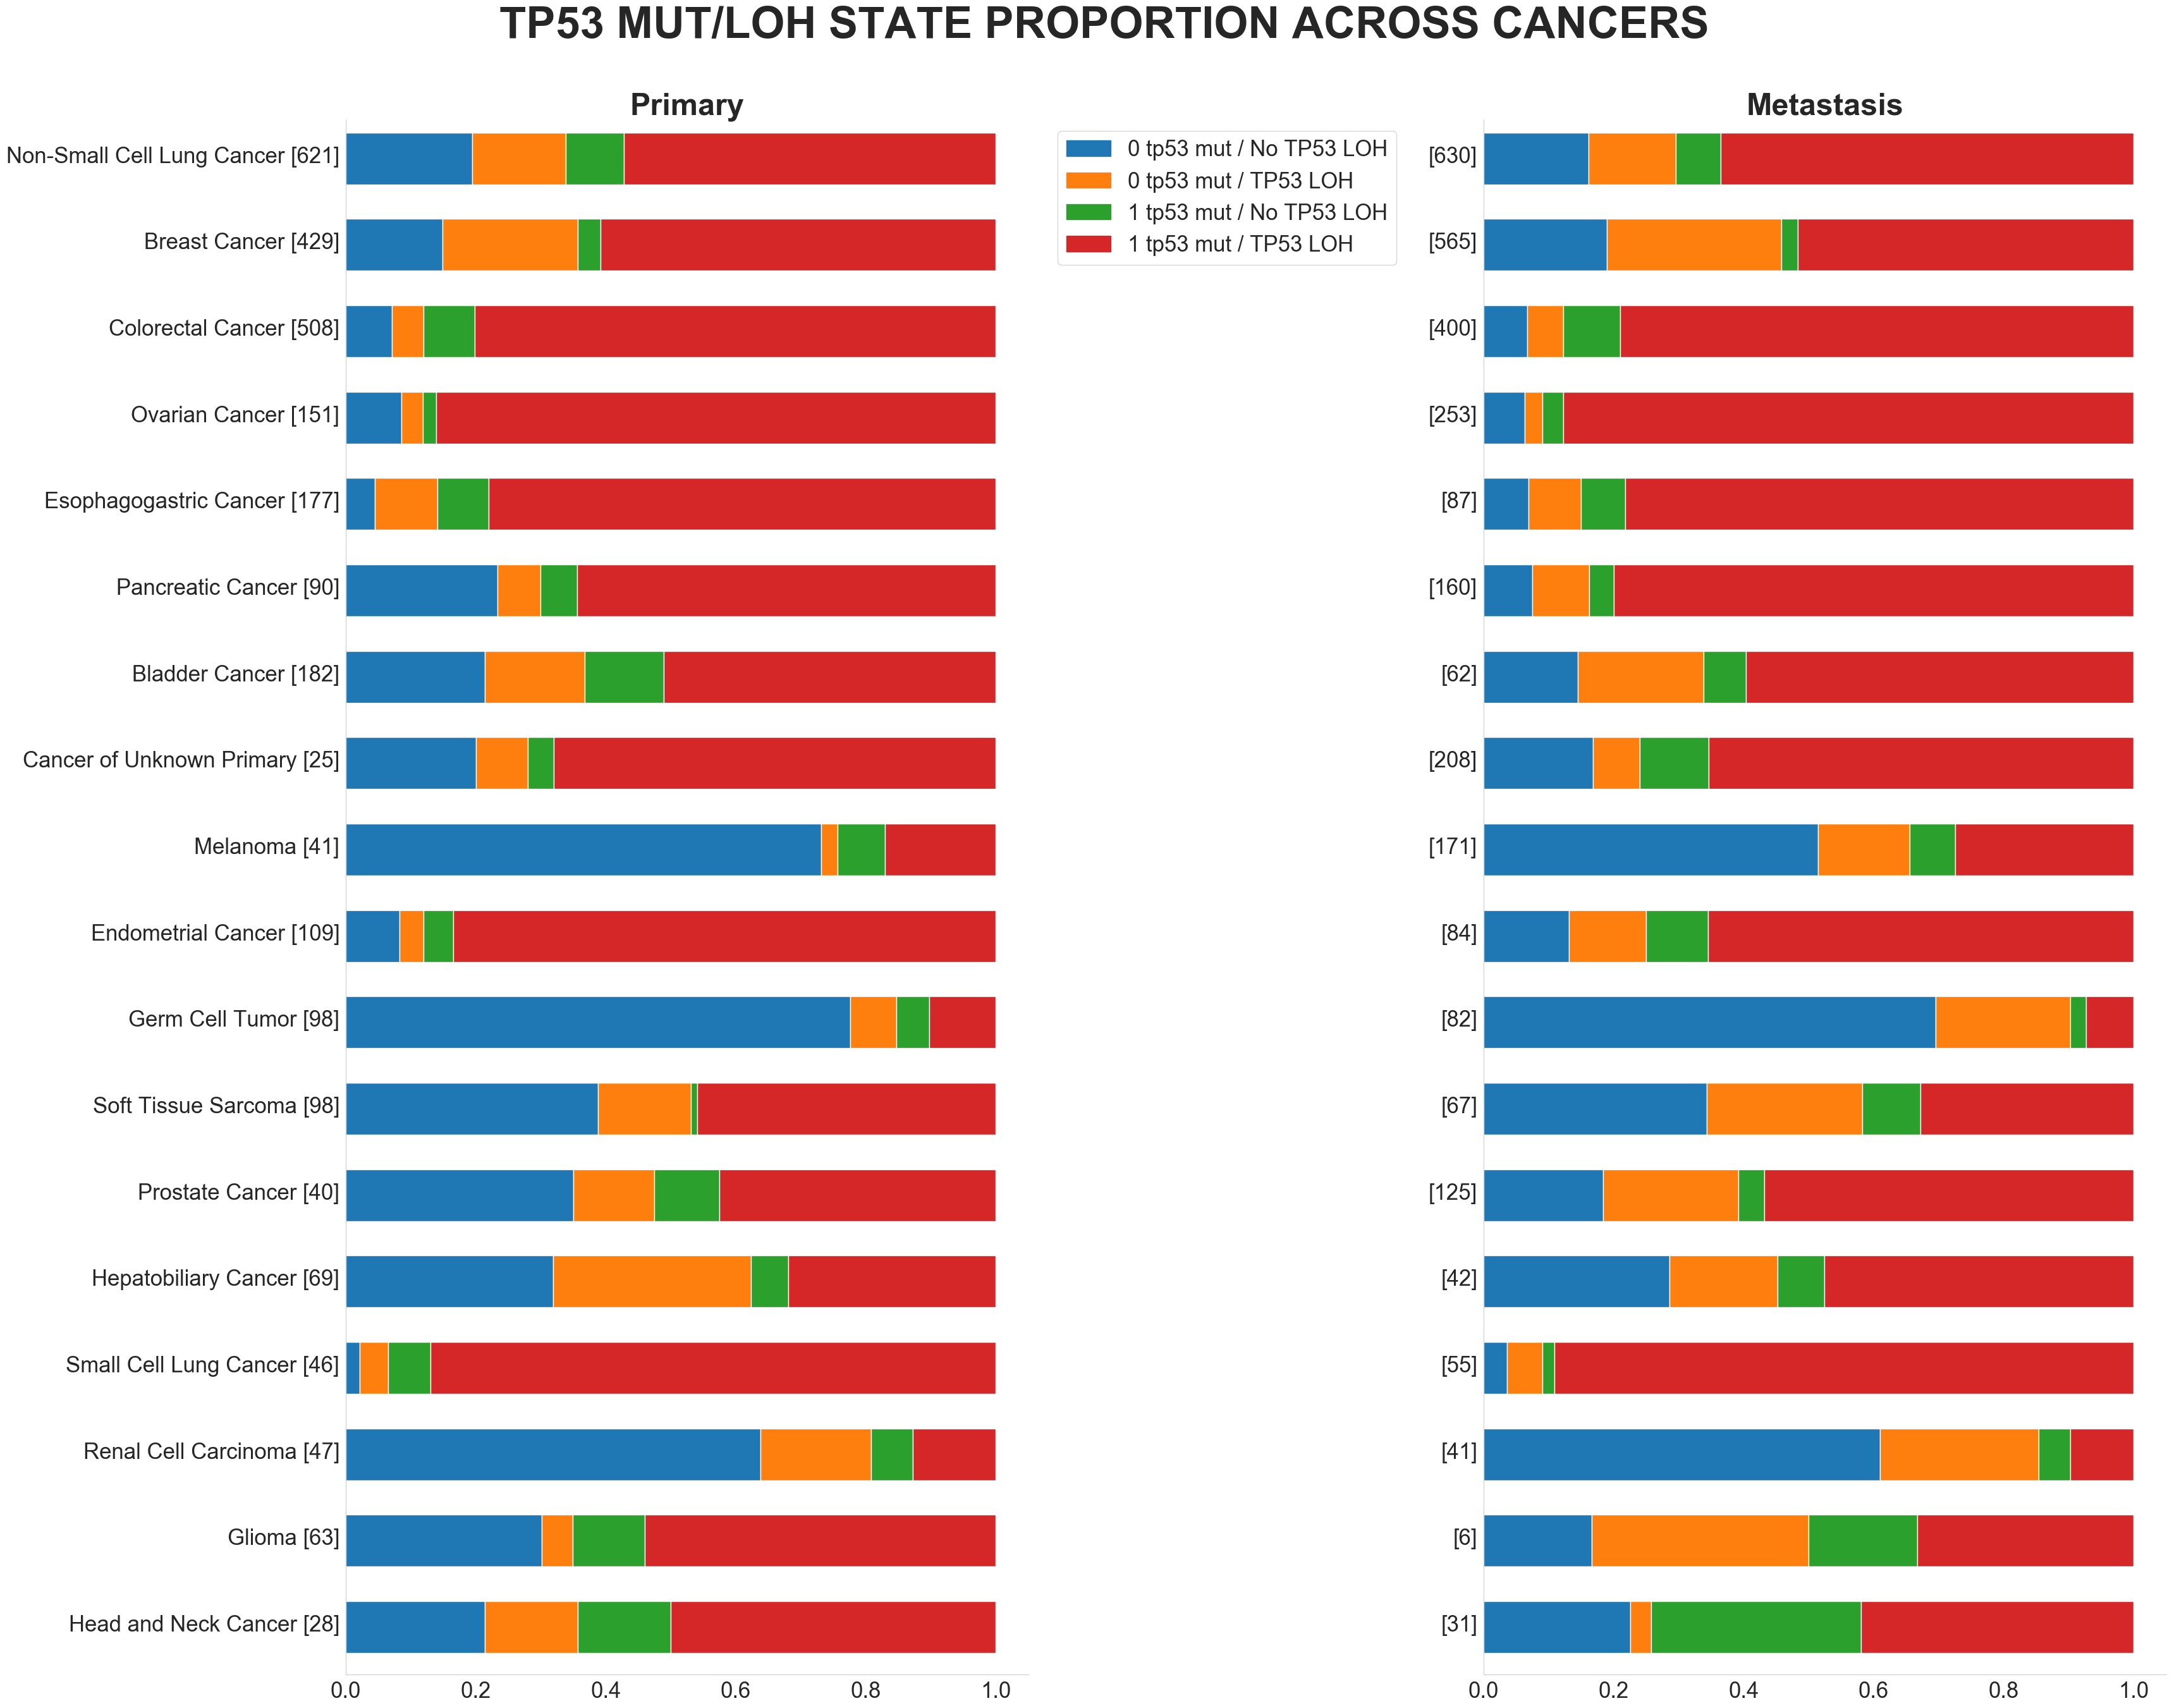

In [11]:
fig = plt.figure(figsize=(40,30))
outer = gridspec.GridSpec(nrows=1, ncols=5)
inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=5, subplot_spec=outer[:1, :5],wspace=0.25, hspace=0)

ax_prim = plt.Subplot(fig, inner[0:2])
ax_legend = plt.Subplot(fig, inner[2])
ax_met = plt.Subplot(fig, inner[3:5])

plot_metrics_cancerlist(master=master_wgd,
                        metrics='tp53_mut_loh_group', 
                        prim_met='Primary', 
                        ax=ax_prim,  
                        legend=True)

res_palette_list = tab10[:4]
res_group_list = ['0 tp53 mut / No TP53 LOH', '0 tp53 mut / TP53 LOH', '1 tp53 mut / No TP53 LOH', '1 tp53 mut / TP53 LOH']

palette = dict(zip(res_group_list, res_palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
ax_legend.legend(handles=handles, fontsize=25, loc='left')
# Get current axes object and turn off axis
ax_legend.set_axis_off()

plot_metrics_cancerlist(master=master_wgd,
                        metrics='tp53_mut_loh_group', 
                        prim_met='Metastasis', 
                        ax=ax_met,  
                        legend=False)

fig.add_subplot(ax_prim)
fig.add_subplot(ax_met)
fig.add_subplot(ax_legend)

fig.subplots_adjust(left=0.2, bottom=0.10, right=0.92, top=0.92, wspace=1, hspace=1)
fig.suptitle('TP53 MUT/LOH STATE PROPORTION ACROSS CANCERS', fontsize=50,fontweight='bold')
fig.savefig('../metrics_analysis/metrics_summaries_wgd/tp53_loh_mut_proportions.pdf', format='pdf')

# Pre WGD TP53 Allelic State

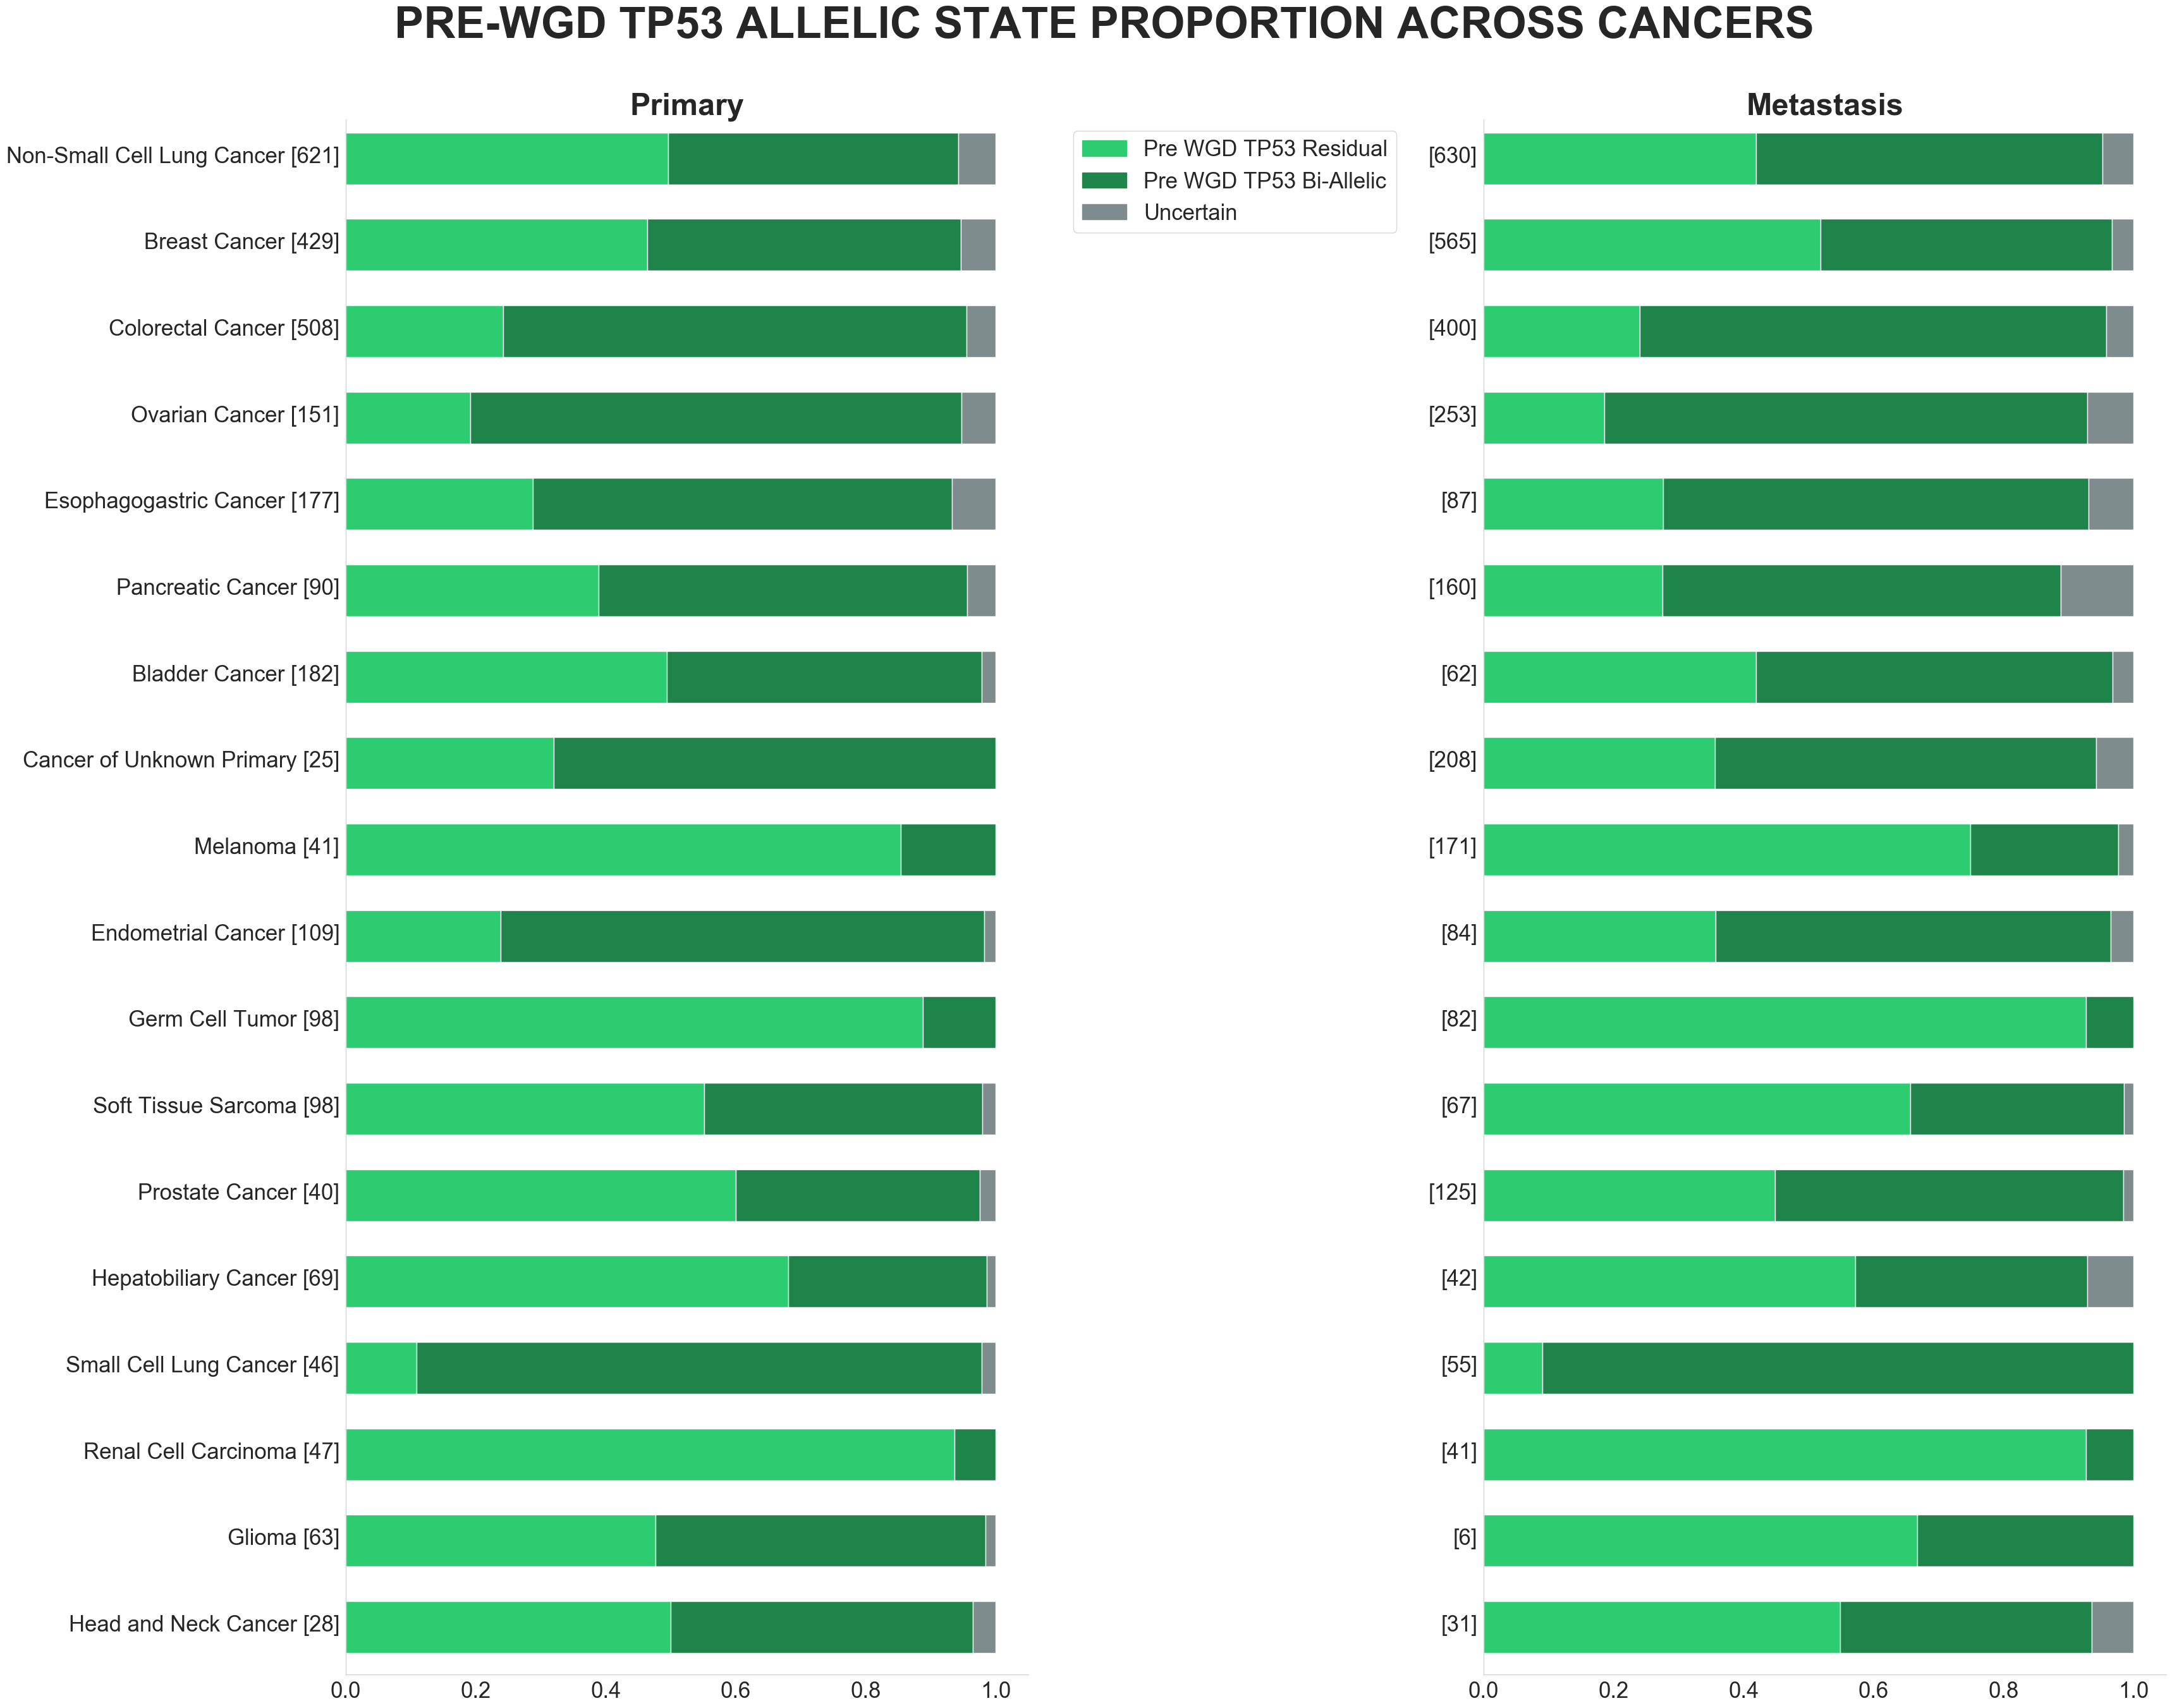

In [8]:
fig = plt.figure(figsize=(40,30))
outer = gridspec.GridSpec(nrows=1, ncols=5)
inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=5, subplot_spec=outer[:1, :5],wspace=0.25, hspace=0)

ax_prim = plt.Subplot(fig, inner[0:2])
ax_legend = plt.Subplot(fig, inner[2])
ax_met = plt.Subplot(fig, inner[3:5])

plot_metrics_cancerlist(master=master_wgd,
                        metrics='prewgd_tp53_group_1_total', 
                        prim_met='Primary', 
                        ax=ax_prim,  
                        legend=True)

res_palette_list = ['#2ECC71','#1E8449', '#7F8C8D']
res_group_list = ['Pre WGD TP53 Residual', 'Pre WGD TP53 Bi-Allelic', 'Uncertain']

palette = dict(zip(res_group_list, res_palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
ax_legend.legend(handles=handles, fontsize=25, loc='left')
# Get current axes object and turn off axis
ax_legend.set_axis_off()

plot_metrics_cancerlist(master=master_wgd,
                        metrics='prewgd_tp53_group_1_total', 
                        prim_met='Metastasis', 
                        ax=ax_met,  
                        legend=False)

fig.add_subplot(ax_prim)
fig.add_subplot(ax_met)
fig.add_subplot(ax_legend)

fig.subplots_adjust(left=0.2, bottom=0.10, right=0.92, top=0.92, wspace=1, hspace=1)
fig.suptitle('PRE-WGD TP53 ALLELIC STATE PROPORTION ACROSS CANCERS', fontsize=50,fontweight='bold')
fig.savefig('../metrics_analysis/metrics_summaries_wgd/pre_wgd_proportions.pdf', format='pdf')

# Pre WGD TP53 Allelic state detailed

In [12]:
def get_allelic_state_det(x):
    if x.prewgd_tp53_group_1 == 'bi':
        return 'bi'
    elif x.prewgd_tp53_group_1 == 'tp53_res':
        if x.tp53_count == 0 and x.tp53_loh_status == False:
            return 'tp53_res_no_hit'
        else:
            return 'tp53_res_hit'
    else: 
        return 'uncertain'

master_wgd['prewgd_tp53_group_1_hit'] = master_wgd.apply(get_allelic_state_det, axis=1)

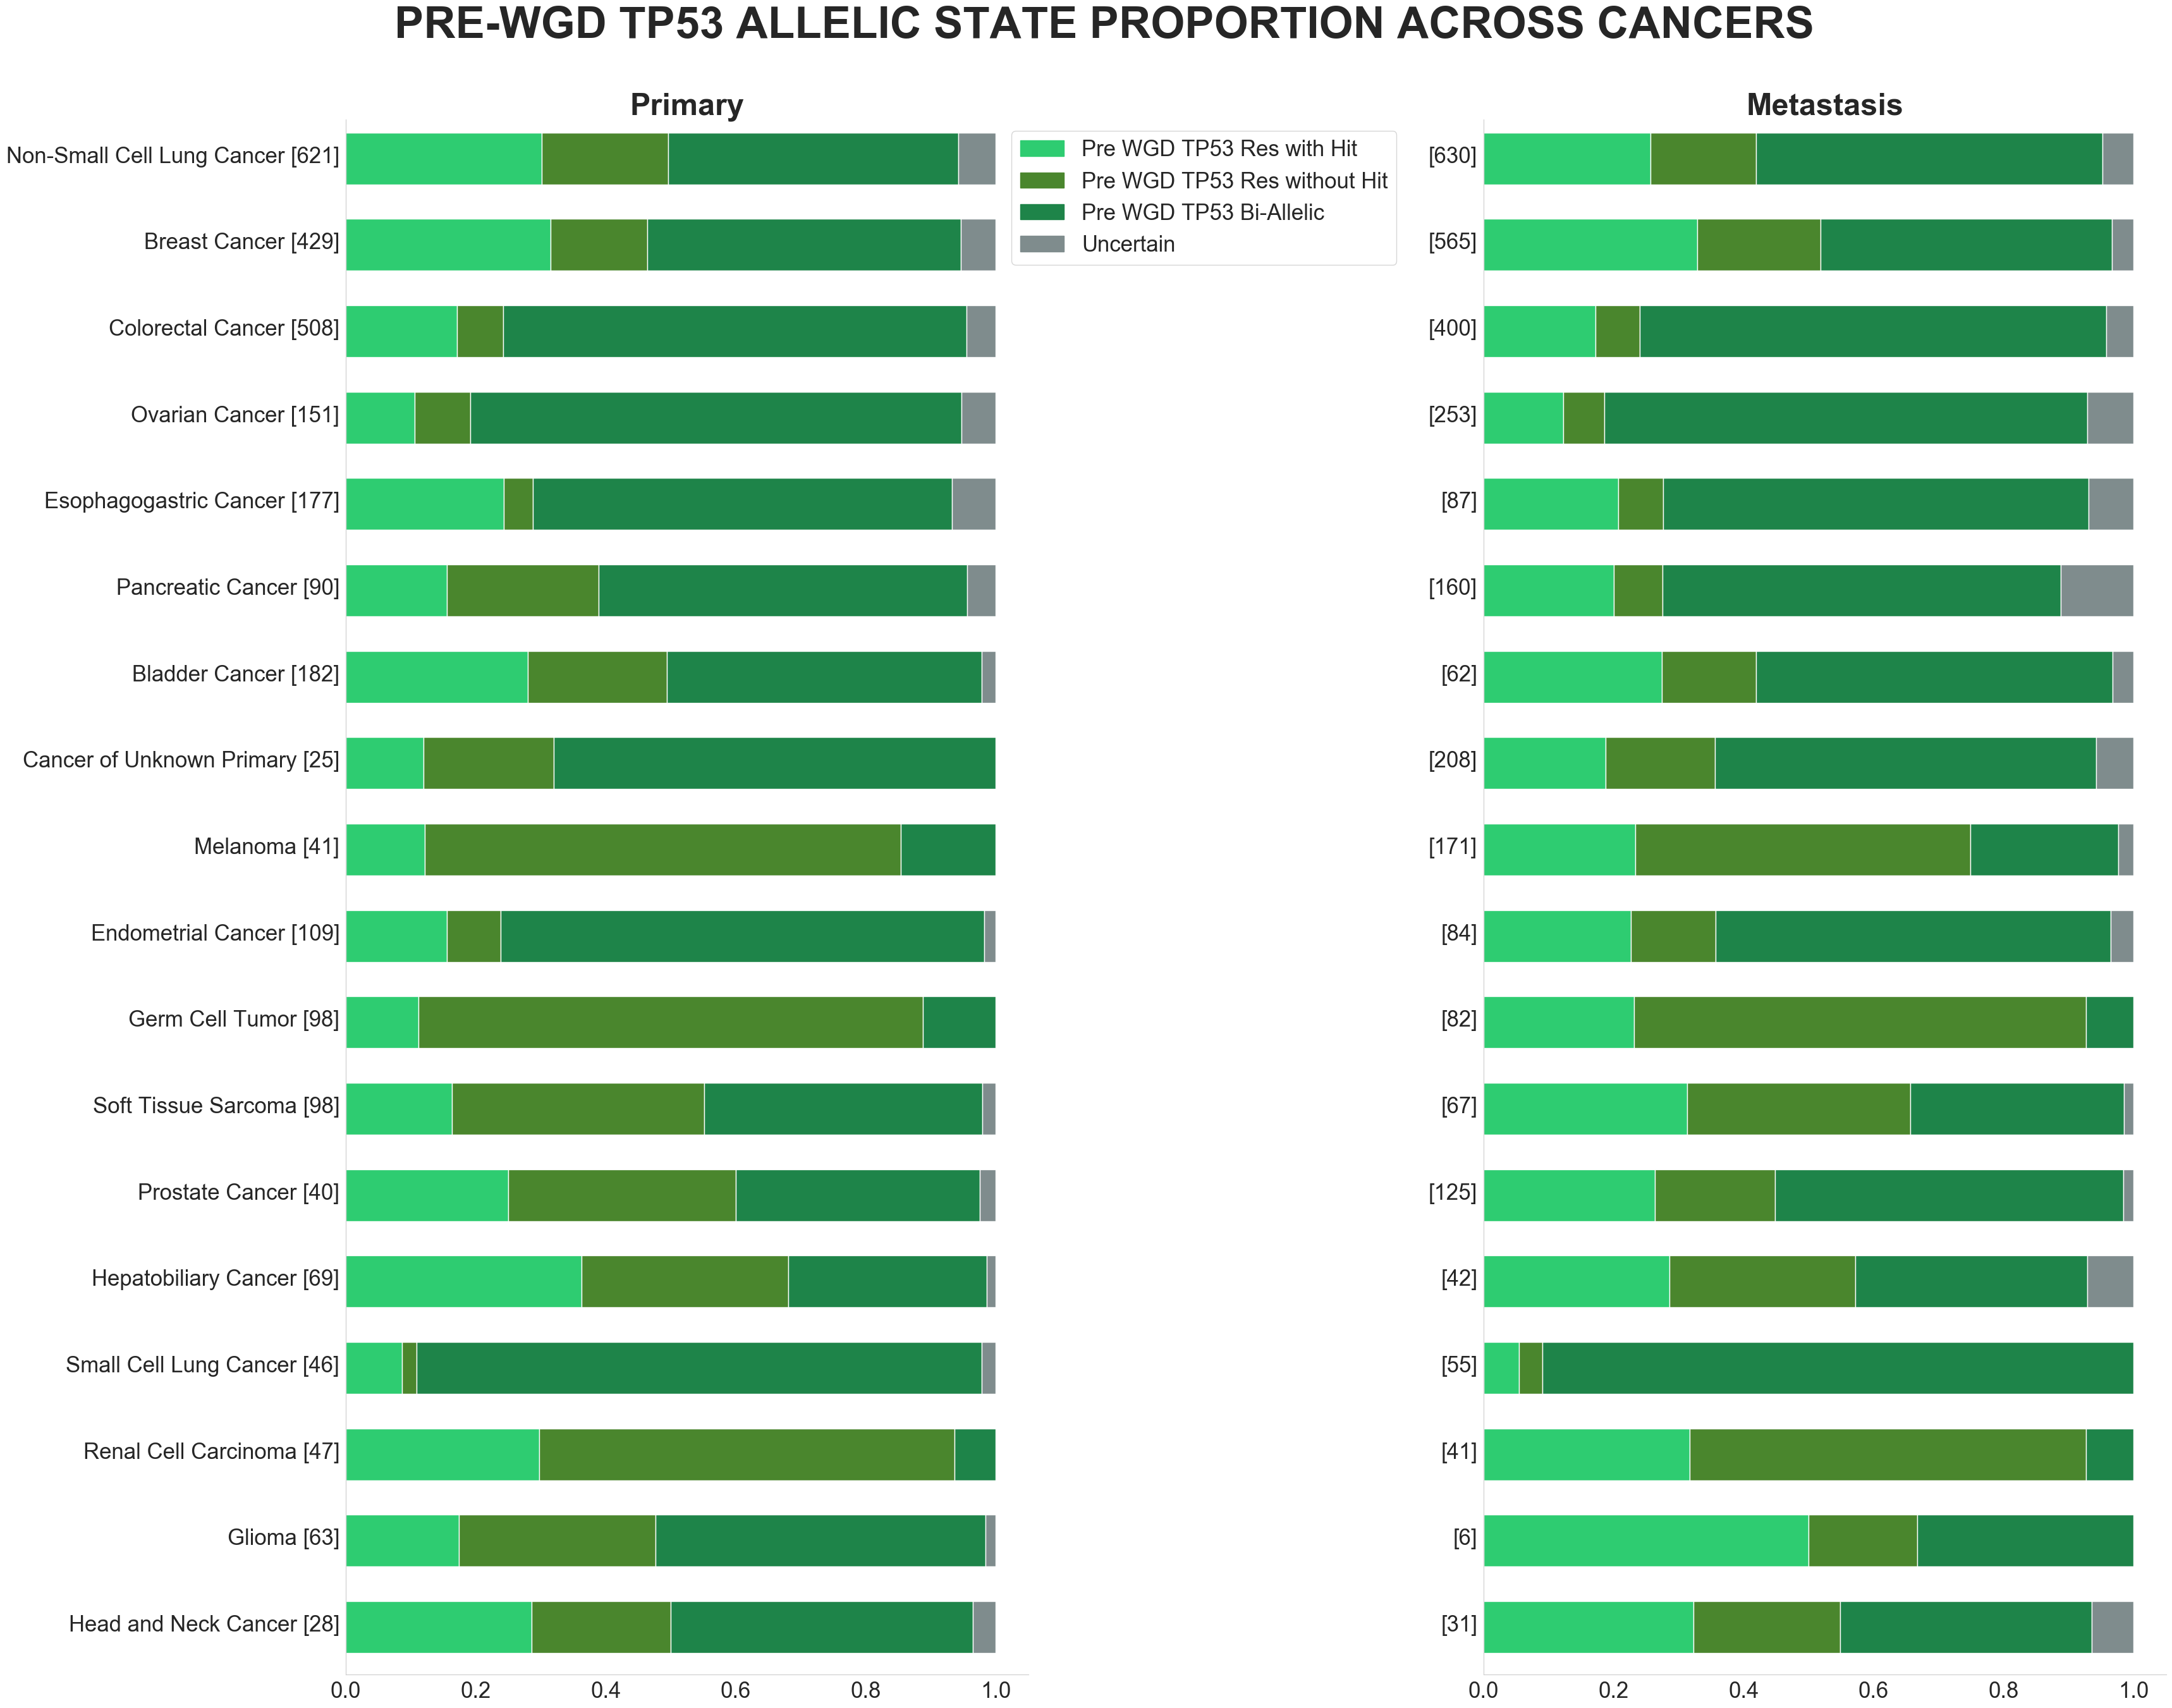

In [21]:
fig = plt.figure(figsize=(40,30))
outer = gridspec.GridSpec(nrows=1, ncols=5)
inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=5, subplot_spec=outer[:1, :5],wspace=0.25, hspace=0)

ax_prim = plt.Subplot(fig, inner[0:2])
ax_legend = plt.Subplot(fig, inner[2])
ax_met = plt.Subplot(fig, inner[3:5])

plot_metrics_cancerlist(master=master_wgd,
                        metrics='prewgd_tp53_group_1_hit', 
                        prim_met='Primary', 
                        ax=ax_prim,  
                        legend=True)

res_palette_list = ['#2ECC71','#4A862D','#1E8449','#7F8C8D']
res_group_list = ['Pre WGD TP53 Res with Hit', 'Pre WGD TP53 Res without Hit', 'Pre WGD TP53 Bi-Allelic', 'Uncertain']

palette = dict(zip(res_group_list, res_palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
ax_legend.legend(handles=handles, fontsize=25, loc='left')
# Get current axes object and turn off axis
ax_legend.set_axis_off()

plot_metrics_cancerlist(master=master_wgd,
                        metrics='prewgd_tp53_group_1_hit', 
                        prim_met='Metastasis', 
                        ax=ax_met,  
                        legend=False)

fig.add_subplot(ax_prim)
fig.add_subplot(ax_met)
fig.add_subplot(ax_legend)

fig.subplots_adjust(left=0.2, bottom=0.10, right=0.92, top=0.92, wspace=1, hspace=1)
fig.suptitle('PRE-WGD TP53 ALLELIC STATE PROPORTION ACROSS CANCERS', fontsize=50,fontweight='bold')
fig.savefig('../metrics_analysis/metrics_summaries_wgd/pre_wgd_hit_proportions.pdf', format='pdf')

# LOH Status

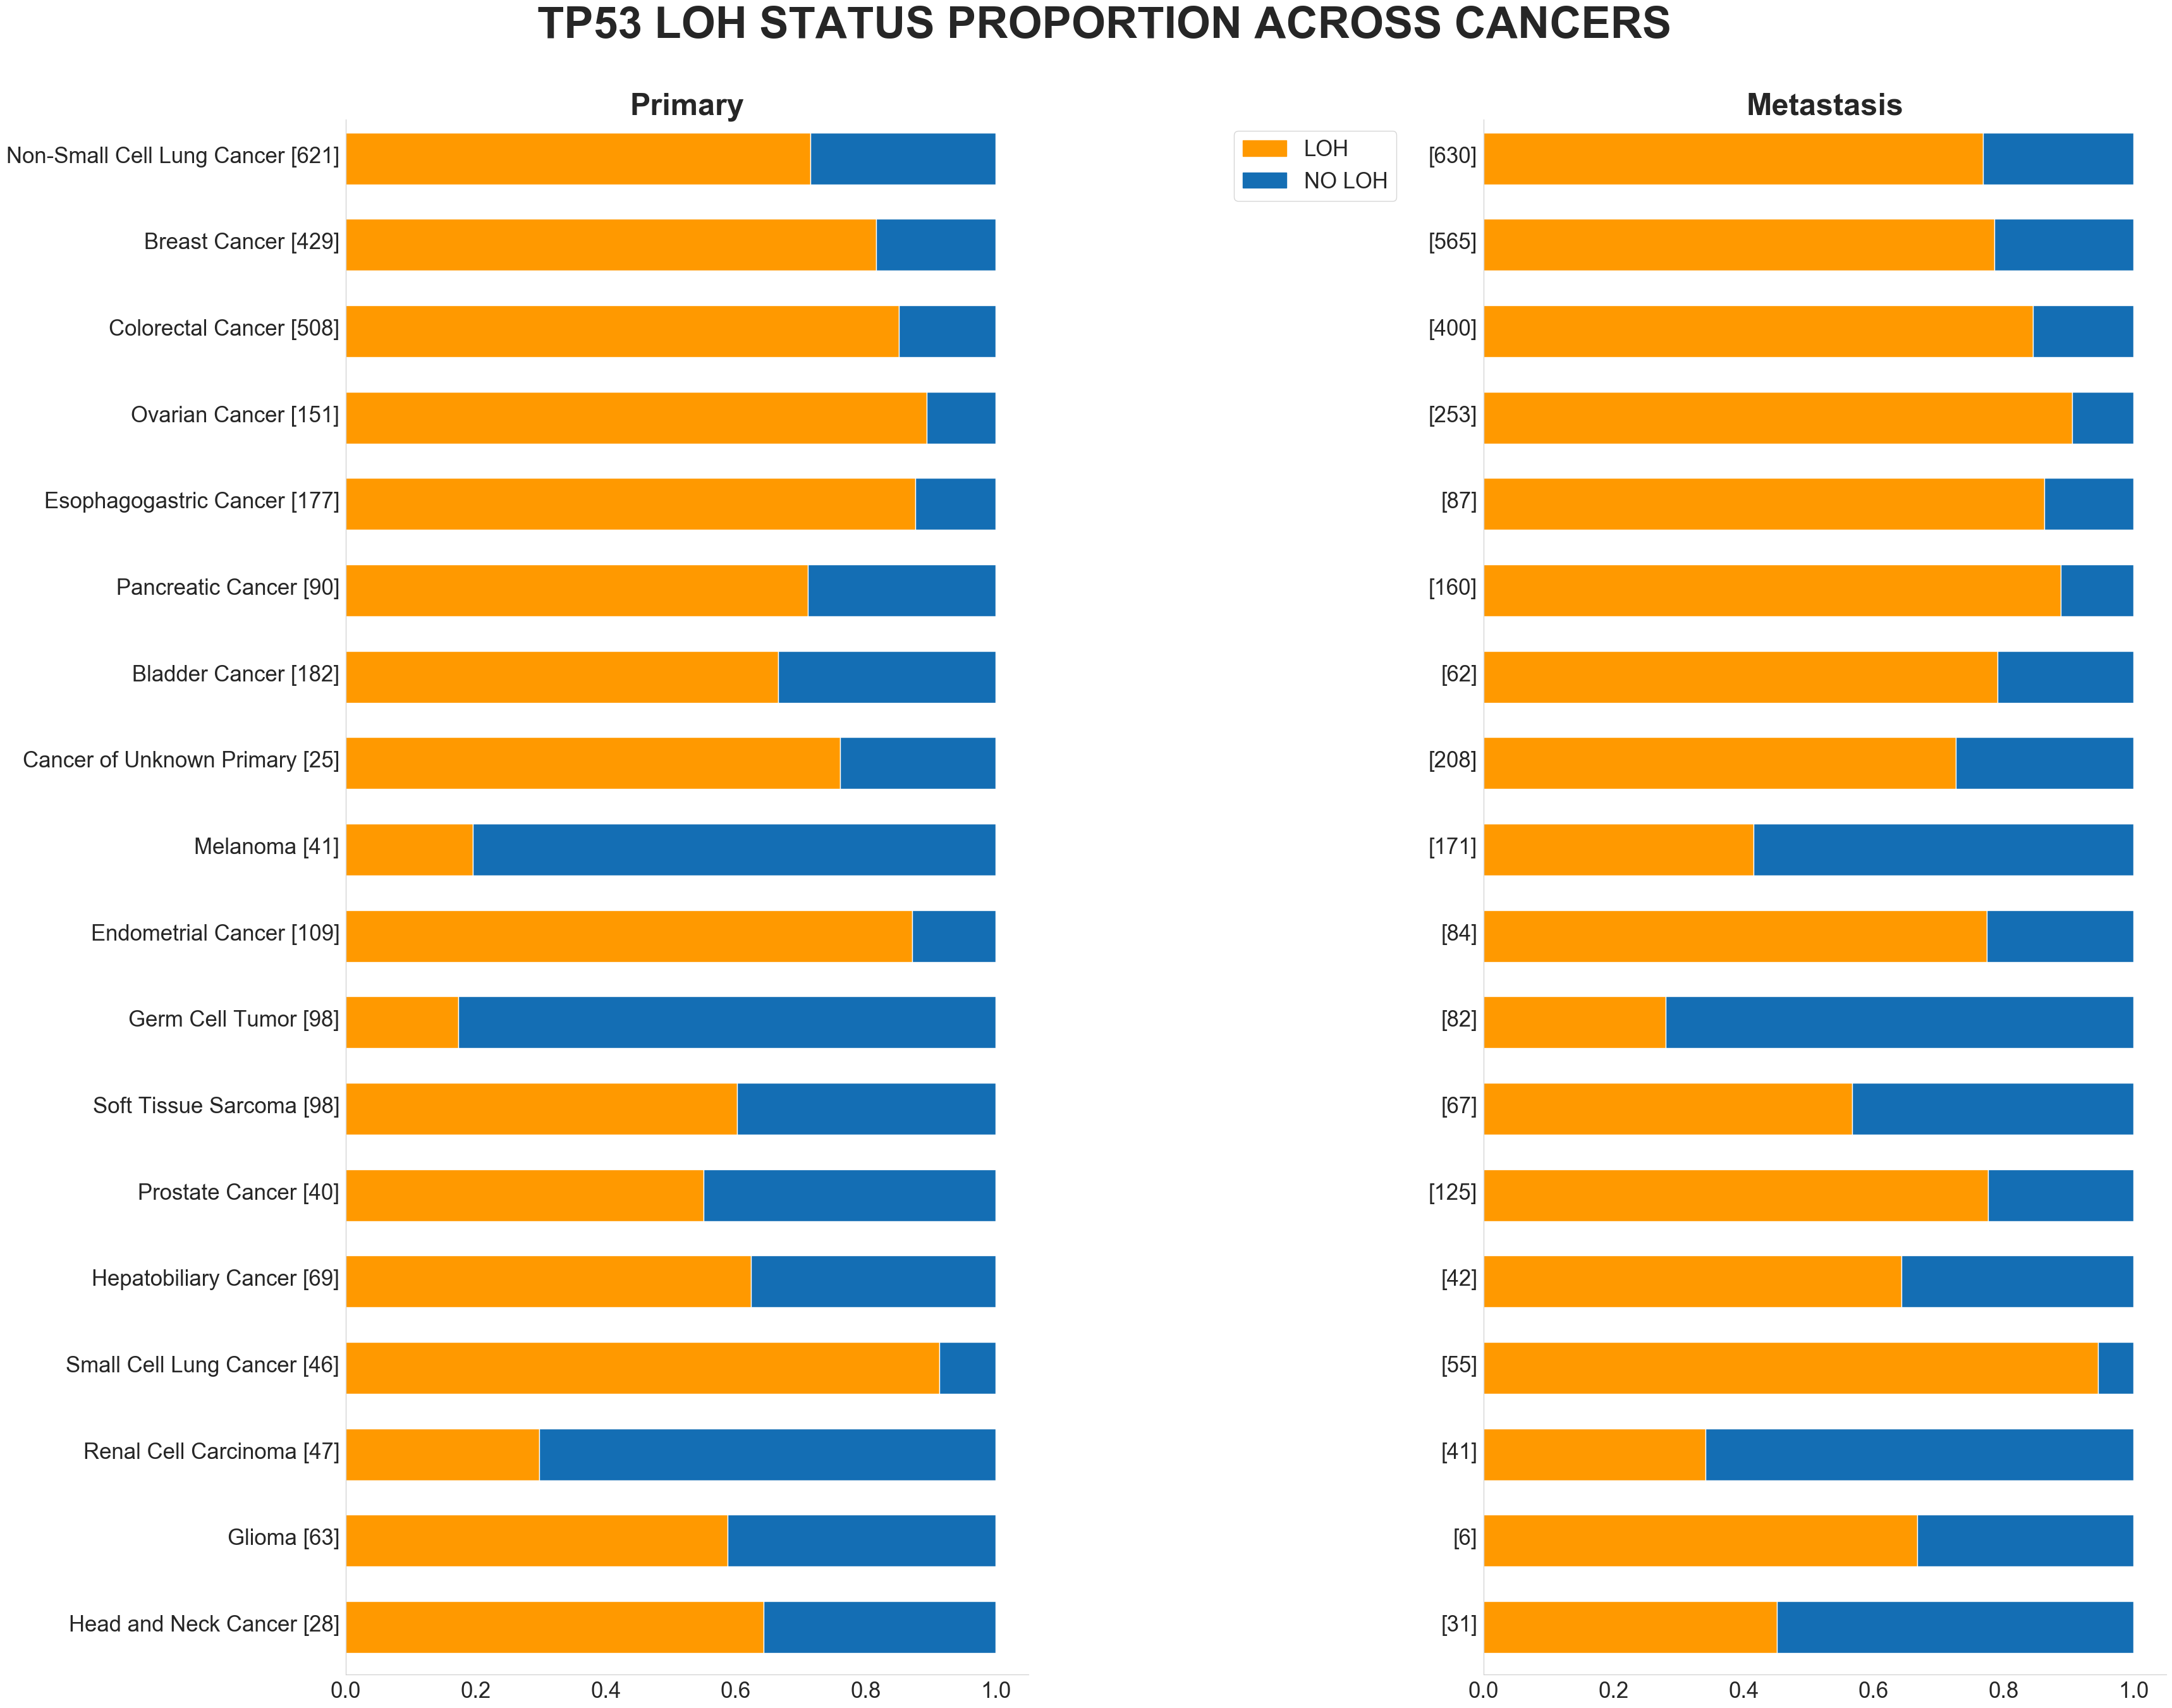

In [19]:
fig = plt.figure(figsize=(40,30))
outer = gridspec.GridSpec(nrows=1, ncols=5)
inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=5, subplot_spec=outer[:1, :5],wspace=0.25, hspace=0)

ax_prim = plt.Subplot(fig, inner[0:2])
ax_legend = plt.Subplot(fig, inner[2])
ax_met = plt.Subplot(fig, inner[3:5])

plot_metrics_cancerlist(master=master_wgd,
                        metrics='tp53_loh_status', 
                        prim_met='Primary', 
                        ax=ax_prim,  
                        legend=True)

palette_list = ['#FF9900', '#146EB4']
list_ = ['LOH', 'NO LOH']

palette = dict(zip(list_, palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
ax_legend.legend(handles=handles, fontsize=25, loc='left')
# Get current axes object and turn off axis
ax_legend.set_axis_off()

plot_metrics_cancerlist(master=master_wgd,
                        metrics='tp53_loh_status', 
                        prim_met='Metastasis', 
                        ax=ax_met,  
                        legend=False)

fig.add_subplot(ax_prim)
fig.add_subplot(ax_met)
fig.add_subplot(ax_legend)

fig.subplots_adjust(left=0.2, bottom=0.10, right=0.92, top=0.92, wspace=1, hspace=1)
fig.suptitle('TP53 LOH STATUS PROPORTION ACROSS CANCERS', fontsize=50,fontweight='bold')
fig.savefig('../metrics_analysis/metrics_summaries_wgd/tp53_loh_proportions.pdf', format='pdf')

In [47]:
tab10[0]

NameError: name 'tab10' is not defined